In [3]:
import nilearn
from nilearn import datasets, image, plotting
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import new_img_like
#import numpy as np
from nilearn import image
#from nilearn.input_data import NiftiLabelsMasker
import nilearn
from nilearn import datasets, image
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker # Use NiftiLabelsMasker
from nilearn.image import resample_to_img, new_img_like
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure # For combined matrix later
import pandas as pd 

In [20]:
atlas_ho_sub = nilearn.datasets.fetch_atlas_harvard_oxford(atlas_name="sub-maxprob-thr25-2mm", data_dir=None, symmetric_split=False, resume=True, verbose=1)

ho_sub_img = image.load_img(atlas_ho_sub['maps'])

# **核心改動：直接使用原始的 labels，因為您確認它們已經是常規字串**
ho_sub_labels = atlas_ho_sub['labels'] # 直接使用，無需 decode


[get_dataset_dir] Dataset found in /Users/m2air/nilearn_data/fsl

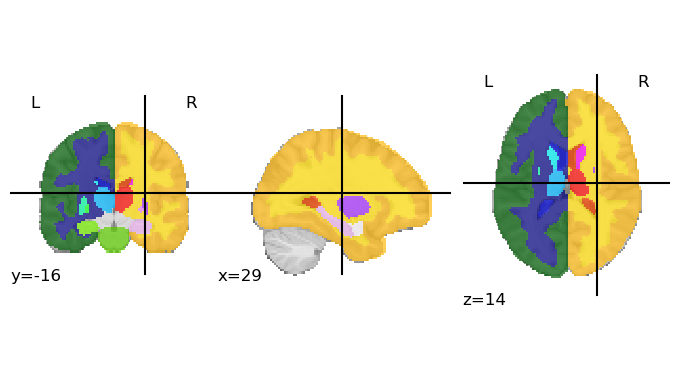

In [21]:
plotting.plot_roi(atlas.maps)

/Users/m2air/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



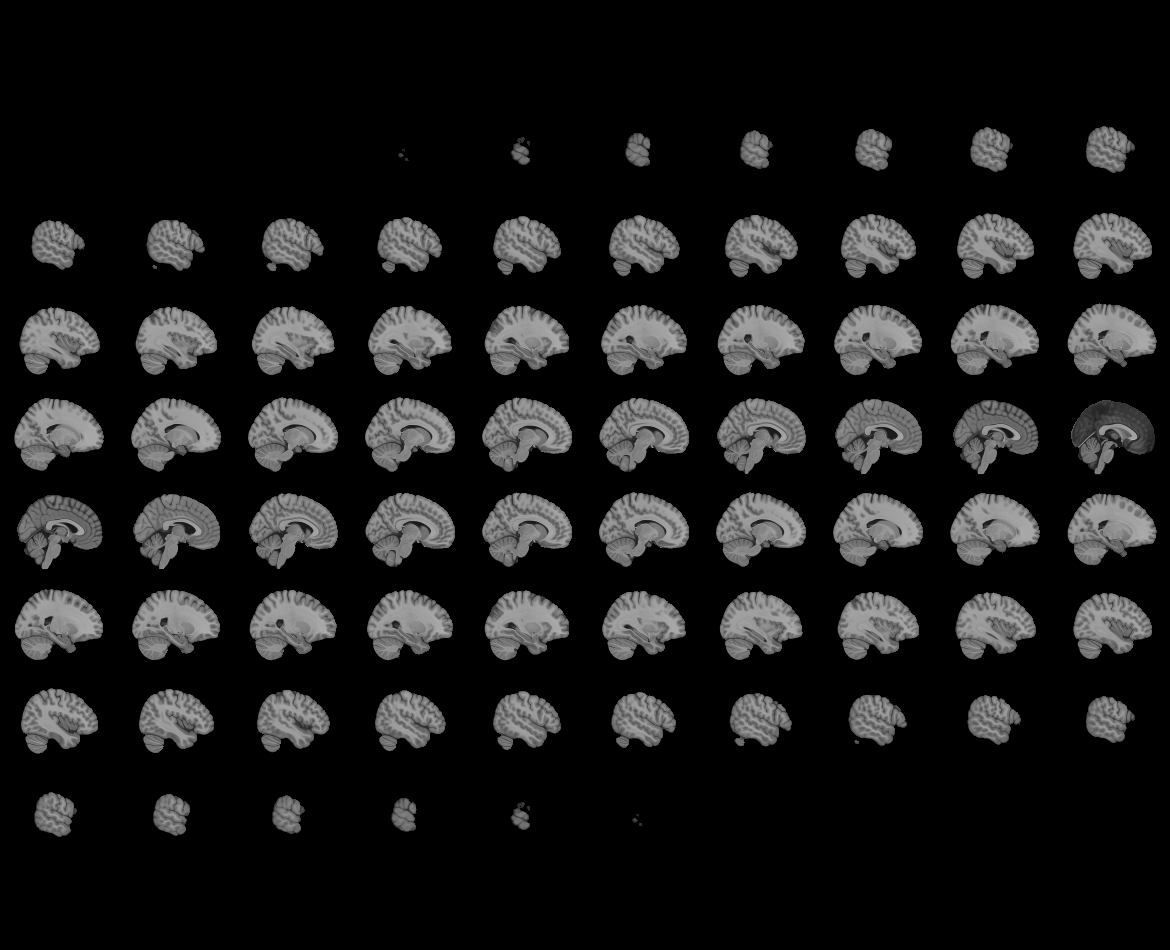
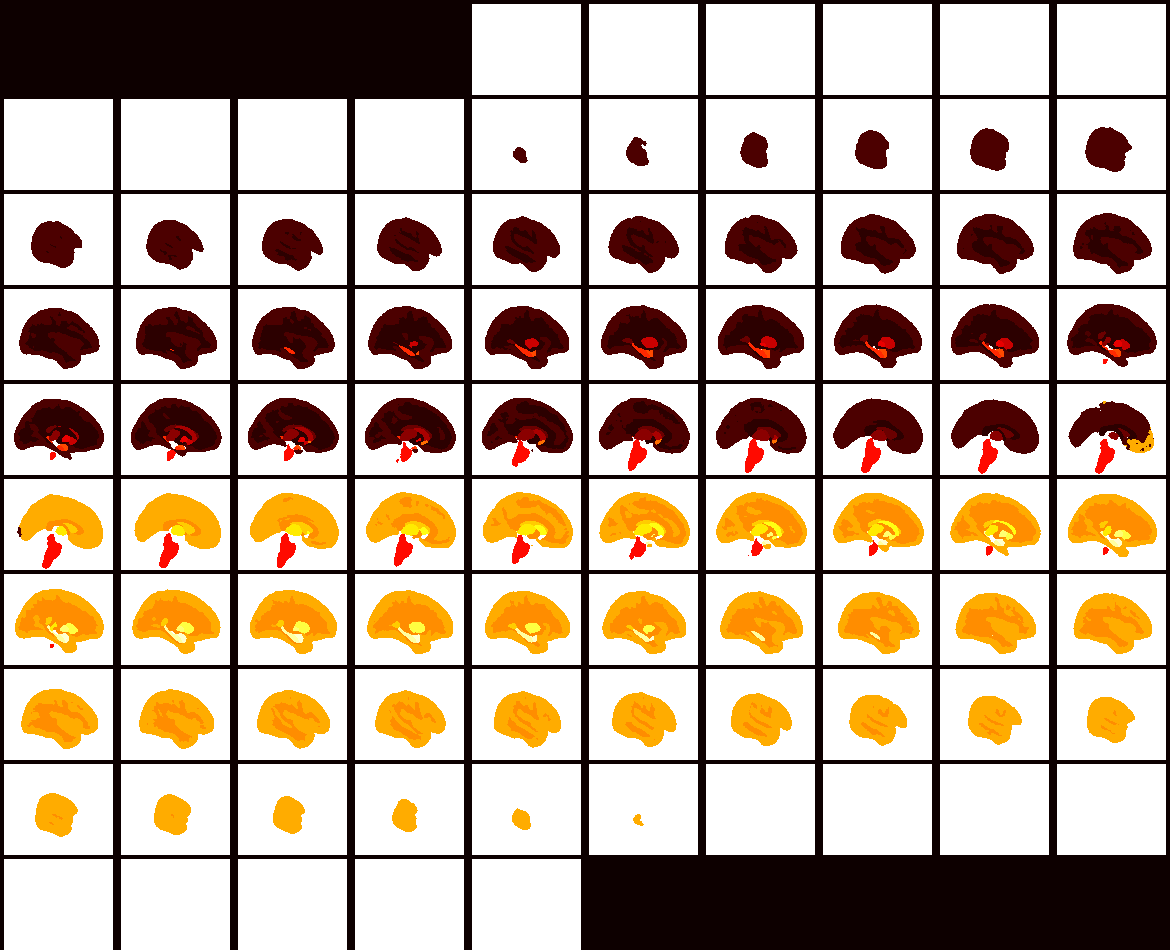

In [22]:
plotting.view_img(atlas.maps)

In [39]:
from nilearn import image
file_path = "/Volumes/SSD/ds003721-download/Processed/Preprocessing_film/S09/Results/errts_S09.nii"

bold_img = image.load_img(file_path)
try:
    t_r = bold_img.header['pixdim'][4]
    if t_r == 0: # 有些文件可能TR為0，需要手動指定
        print("警告: BOLD 影像頭信息中的 TR 為 0，請手動指定 t_r。")
        t_r = 1.19 # 請根據您的數據實際TR修改
except IndexError: # 如果沒有 'pixdim' 這個鍵
    print("警告: 無法從 BOLD 影像頭信息中獲取 TR，請手動指定 t_r。")
    t_r = 2.19 # 請根據您的數據實際TR修改

bold_img = image.load_img(file_path)
print(bold_img.shape)

(96, 114, 96, 2100)


In [40]:
ho_sub_img = image.load_img(atlas_ho_sub['maps'])

# **核心改動：直接使用原始的 labels，因為您確認它們已經是常規字串**
ho_sub_labels = atlas['labels'] # 直接使用，無需 decode

#print(f"\n--- Harvard-Oxford Subcortical Atlas Labels ({atlas_name_to_use}) ---")
# 打印所有標籤，確認它們是您期望的常規字串格式
for i, label in enumerate(ho_sub_labels):
    print(f"Index {i}: {label}")

# --- 3. 精確識別 Left Putamen 和 Right Putamen ---
basal_ganglia_keywords_ho = [
    'Left Putamen',
    'Right Putamen'
]

# 根據這些精確的關鍵字獲取 ROI 索引
basal_ganglia_roi_indices_ho = [
    i + 1 for i, label in enumerate(ho_sub_labels) # 使用未經 decode 的 ho_sub_labels
    if label in basal_ganglia_keywords_ho
]

# 確保我們找到了這些標籤
if not basal_ganglia_roi_indices_ho:
    print("\n!! 錯誤: 未在 Harvard-Oxford atlas 中找到 'Left Putamen' 或 'Right Putamen' !!")
    print("請檢查上面的 atlas labels 輸出，確認名稱是否完全匹配。")
else:
    print(f"\n已選定 {len(basal_ganglia_roi_indices_ho)} 個 Basal Ganglia ROI (Harvard-Oxford):")
    selected_ho_labels = [ho_sub_labels[idx - 1] for idx in basal_ganglia_roi_indices_ho]
    print(selected_ho_labels)


Index 0: Background
Index 1: Left Cerebral White Matter
Index 2: Left Cerebral Cortex
Index 3: Left Lateral Ventricle
Index 4: Left Thalamus
Index 5: Left Caudate
Index 6: Left Putamen
Index 7: Left Pallidum
Index 8: Brain-Stem
Index 9: Left Hippocampus
Index 10: Left Amygdala
Index 11: Left Accumbens
Index 12: Right Cerebral White Matter
Index 13: Right Cerebral Cortex
Index 14: Right Lateral Ventricle
Index 15: Right Thalamus
Index 16: Right Caudate
Index 17: Right Putamen
Index 18: Right Pallidum
Index 19: Right Hippocampus
Index 20: Right Amygdala
Index 21: Right Accumbens

已選定 2 個 Basal Ganglia ROI (Harvard-Oxford):
['Left Putamen', 'Right Putamen']


In [41]:
ho_sub_resampled = resample_to_img(ho_sub_img, bold_img, interpolation='nearest')

ho_sub_data = ho_sub_resampled.get_fdata()
basal_ganglia_mask_data_ho = np.where(
    np.isin(ho_sub_data, basal_ganglia_roi_indices_ho),
    ho_sub_data,
    0
)
basal_ganglia_mask_img_ho = new_img_like(ho_sub_resampled, basal_ganglia_mask_data_ho, copy_header=True)


/var/folders/_w/vwhzp6ss24j30595sp9s9d900000gn/T/ipykernel_48712/2434647693.py:1: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  ho_sub_resampled = resample_to_img(ho_sub_img, bold_img, interpolation='nearest')
/Users/m2air/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [42]:
print(f"\n正在使用 NiftiLabelsMasker 提取 Left/Right Putamen 時間序列...")
masker_ho = NiftiLabelsMasker(
    labels_img=basal_ganglia_mask_img_ho,
    standardize=True,
    detrend=True,
    low_pass=0.1, high_pass=0.01, t_r=t_r,
    n_jobs=4 # 保持 n_jobs=4 或根據您的系統資源調整
)


正在使用 NiftiLabelsMasker 提取 Left/Right Putamen 時間序列...


In [43]:
time_series_putamen = masker_ho.fit_transform(bold_img)
print(f"Left/Right Putamen 時間序列形狀 (Harvard-Oxford): {time_series_putamen.shape}")


Left/Right Putamen 時間序列形狀 (Harvard-Oxford): (2100, 2)


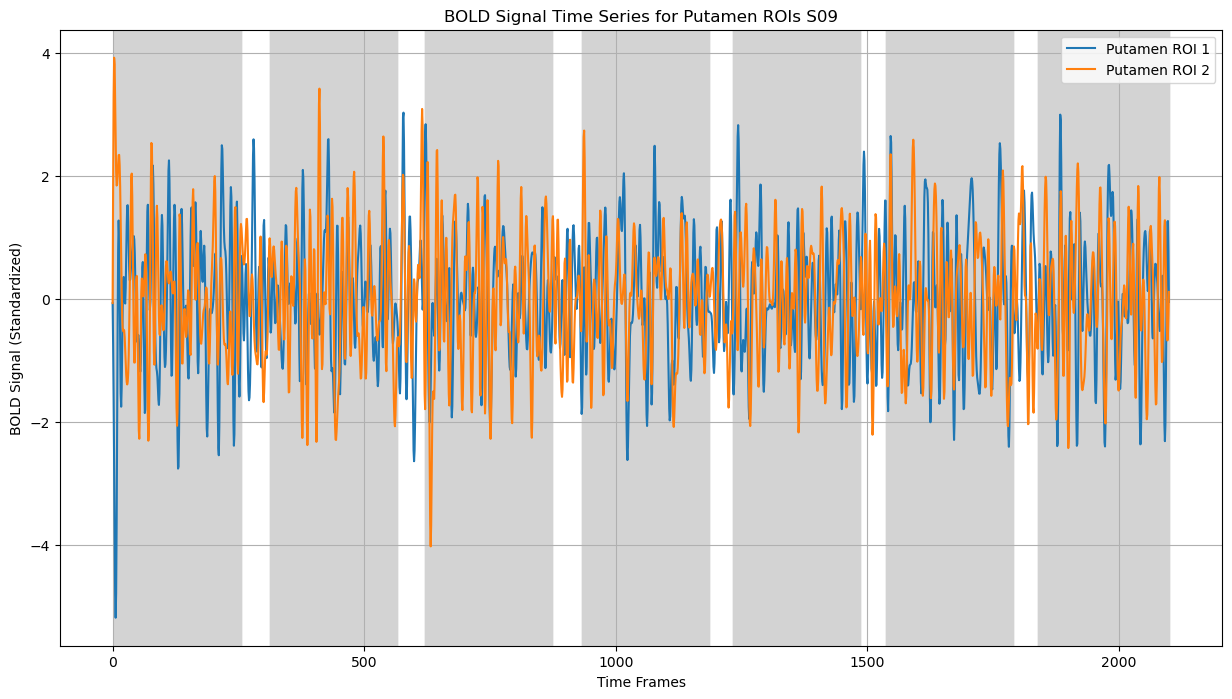

In [44]:
import matplotlib.pyplot as plt

# 假設 time_series_dmn 的形狀是 (2100, 35)
num_dmn_rois = time_series_putamen.shape[1]

plt.figure(figsize=(15, 8))
for i in range(min(13, num_dmn_rois)): # 這裡只繪製前5個DMN ROI的時序作為範例
    plt.plot(time_series_putamen[:, i], label=f'Putamen ROI {i+1}') # 可以根據 labels 獲取實際的 ROI 名稱
    rest0 = [3, 256]
    rest1 = [313, 566]
    rest2 = [620,873]
    rest3 = [933, 1186]
    rest4 = [1232,1485]
    rest5 = [1537,1790]
    rest6 = [1838, 2100]
    rest_periods = [rest0,rest1, rest2, rest3, rest4,rest5,rest6]
    for rest in rest_periods:
        plt.axvspan(xmin=rest[0], xmax=rest[1], ymax=1, color="lightgray",zorder=0)

plt.title('BOLD Signal Time Series for Putamen ROIs S09')
plt.xlabel('Time Frames')
plt.ylabel('BOLD Signal (Standardized)')
plt.legend()
plt.grid(True)
plt.show()